In [7]:
import datetime
import requests
import numpy as np
import pandas as pd
import spacy
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import seaborn as sns

In [8]:
yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
yesterday_string = yesterday.strftime("%Y-%m-%d")
print(yesterday_string)

2019-02-13


In [11]:
def get_news_page(PAGE=1):
    API_KEY = 'b526abc1d7af430e8bafc94cbe20ad93'
    TOPIC = 'Denmark'
    SORTBY = 'popularity'
    FROM = '2019-02-04'
    TO = '2019-02-05'

    URL = 'https://newsapi.org/v2/everything'
    PARAMS = {'q': TOPIC,
              'from': FROM,
              'to': TO,
              'sortBy': SORTBY,
              'pageSize': 100,
              'page': PAGE,
              'apiKey': API_KEY}

    response = requests.get(url=URL, params=PARAMS).json()
    return response

In [12]:
def get_news():
    articles = list()

    PAGE = 0
    while True:
        PAGE += 1
        news_page = get_news_page(PAGE)
        status = news_page['status']
        if status == 'ok':
            articles += news_page['articles']
        else:
            print('Number of articles available:', len(articles))
            break
    return articles

In [13]:
articles = get_news()
articles

Number of articles available: 457


[{'source': {'id': 'techcrunch', 'name': 'TechCrunch'},
  'author': 'Ingrid Lunden',
  'title': '2nd Address picks up $10M from GV, Foundation to take on Airbnb in business travel',
  'description': 'As Airbnb adds more features to court business users, a smaller startup has raised some funding to take it on in the $18 billion business travel market. 2nd Address, an Airbnb-style platform for business travellers looking for home rentals that extend beyond …',
  'url': 'http://techcrunch.com/2019/02/04/2nd-address-picks-up-10m-from-gv-foundation-to-take-on-airbnb-in-business-travel/',
  'urlToImage': 'https://techcrunch.com/wp-content/uploads/2019/02/Screenshot-2019-02-04-at-15.58.52.png?w=603',
  'publishedAt': '2019-02-04T16:00:46Z',
  'content': 'As Airbnb adds more features to court business users, a smaller startup has raised some funding to take it on in the $18 billion business travel market. 2nd Address, an Airbnb-style platform for business travellers looking for home rentals th

In [14]:
nlp = spacy.load('en_core_web_sm')

In [16]:
def extract_fields(articles):
    ids_ = list()
    sources = list()
    titles = list()
    publishedAts = list()

    i = 0
    for article in articles:
        source = article['source']['name']
        title = article['title']
        publishedAt = datetime.datetime.strptime(article['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')

        ids_.append(i)
        sources.append(source)
        titles.append(title)
        publishedAts.append(publishedAt)
        i += 1
    
    return ids_, sources, titles, publishedAts

ids_, sources, titles, publishedAts = extract_fields(articles)

In [19]:
def get_labels(titles, publishedAts, ids_):
    labels = list()

    for title, publishedAt, id_ in zip(titles, publishedAts, ids_):
        if title is not None:
            doc = nlp(title)
            for ent in doc.ents:
                labels.append([id_, publishedAt, ent.text, ent.label_])

    labels = pd.DataFrame(labels, columns=['id', 'publishedAt', 'label', 'class'])
    return labels

labels = get_labels(titles, publishedAts, ids_)

In [9]:
toptopics = labels[[l in ['ORG', 'PERSON', 'GPE'] for l in labels['class']]]
toptopics = toptopics.groupby(['label','class']).count()['id'].reset_index()
toptopics['class_rank'] = toptopics.groupby('class')['id'].rank(method='first', ascending=False)
toptopics.pivot(index='class_rank', columns='class', values='label').head()

class,GPE,ORG,PERSON
class_rank,,,
1.0,Virginia,Mamata,Ralph Northam
2.0,Venezuela,Hvper.com,Northam
3.0,US,Fox News,Justin Fairfax
4.0,El Salvador,CBI,Donald Trump
5.0,Fairfax,State of the Union,Nayib Bukele


In [10]:
labels['publishedAt'] = labels['publishedAt'].map(lambda x: x.replace(second=0, minute=0, hour=0))

In [11]:
trendingtopics = labels.groupby(['label', 'publishedAt']).count()['id'].reset_index()
id_count = trendingtopics.groupby('publishedAt').sum()
trendingtopics = trendingtopics.join(id_count, on='publishedAt', rsuffix='_total')
trendingtopics['prob'] = trendingtopics['id'].div(trendingtopics['id_total'])
trendingtopics = trendingtopics[trendingtopics['id'] >= 3]
trendingtopics['prob_lag'] = trendingtopics.sort_values(['label', 'publishedAt']).groupby(['label'])['prob'].shift(periods=1, fill_value = 3)
trendingtopics = trendingtopics[trendingtopics['publishedAt'] == '2019-02-05']
trendingtopics['KL_divergence'] = trendingtopics['prob'].mul(np.log(trendingtopics['prob'].div(trendingtopics['prob_lag'])))
trendingtopics.sort_values('KL_divergence', ascending=False).head()

,label,publishedAt,id,id_total,prob,prob_lag,KL_divergence
289,Democrats,2019-02-05,15,943,0.015907,0.008083,0.010768
601,Mamata,2019-02-05,10,943,0.010604,0.005774,0.006447
1076,US,2019-02-05,9,943,0.009544,0.005774,0.004797
1029,Trump,2019-02-05,10,943,0.010604,0.006928,0.004514
182,CBI,2019-02-05,5,943,0.005302,0.003464,0.002257


In [12]:
Counter(sources).most_common()

[('Yahoo.com', 46),
 ('Independent', 33),
 ('Firstpost.com', 32),
 ('The Guardian (AU)', 30),
 ('Indianexpress.com', 25),
 ('Forbes.com', 22),
 ('Bostonglobe.com', 19),
 ('The New York Times', 18),
 ('ABC News (AU)', 18),
 ('Sputniknews.com', 16),
 ('CNN', 15),
 ('USA Today', 15),
 ('Financial Times', 15),
 ('Seattletimes.com', 15),
 ('Fox News', 14),
 ('The Hindu', 13),
 ('Rawstory.com', 13),
 ('Theweek.com', 12),
 ('Dailycaller.com', 12),
 ('Washingtonexaminer.com', 11),
 ('National Review', 11),
 ('News18.com', 11),
 ('Fastcompany.com', 10),
 ('Hvper.com', 10),
 ('Redstate.com', 10),
 ('BBC News', 9),
 ('Time', 9),
 ('RT', 9),
 ('Moneycontrol.com', 9),
 ('Euronews.com', 8),
 ('Thedailybeast.com', 8),
 ('Seekingalpha.com', 8),
 ('Globalresearch.ca', 8),
 ('Reuters', 7),
 ('Vice News', 7),
 ('Politico', 7),
 ('Al Jazeera English', 7),
 ('MSNBC', 7),
 ('Hotair.com', 7),
 ('Talkingpointsmemo.com', 7),
 ('Boingboing.net', 6),
 ('The Huffington Post', 6),
 ('Theatlantic.com', 6),
 ('Insid

In [13]:
text_vectors = [nlp(title).vector.tolist() if title is not None else None for title in titles]
X_train, X_test, y_train, y_test = train_test_split(text_vectors, sources, test_size=0.1, random_state=0)

In [14]:
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)

C:\Users\rknudsen\AppData\Local\Continuum\miniconda3\envs\trendingtopics\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=0, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [15]:
model.score(X_test, y_test)

0.15

In [16]:
model.predict(X_test)

array(['Dw.com', 'Hvper.com', 'Indianexpress.com', 'Independent',
       'News18.com', 'News18.com', 'Independent', 'RT', 'News18.com',
       'Indianexpress.com', 'Dailycaller.com', 'Independent',
       'Rawstory.com', 'Firstpost.com', 'Firstpost.com', 'CNN',
       'Dailycaller.com', 'Forbes.com', 'Bostonglobe.com', 'Independent',
       'Firstpost.com', 'Politico', 'Forbes.com', 'Buzzfeednews.com',
       'Firstpost.com', 'Independent', 'The New York Times',
       'Dailysignal.com', 'The Guardian (AU)', 'Forbes.com',
       'Globalsecurity.org', 'Financial Times', 'USA Today',
       'The New York Times', 'Forbes.com', 'Time', 'Dailycaller.com',
       'Businesswire.com', 'Redstate.com', 'Theatlantic.com', 'The Hindu',
       'Firstpost.com', 'Independent', 'Firstpost.com', 'Theatlantic.com',
       'Bostonglobe.com', 'Time', 'Firstpost.com', 'Politico',
       'Yahoo.com', 'Independent', 'Time', 'The New York Times',
       'Espn.com', 'Financial Times', 'The Guardian (AU)',
    

In [17]:
embeddings = TSNE(n_components=2).fit_transform(text_vectors)

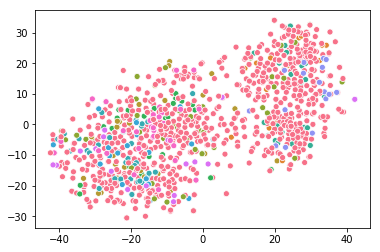

In [30]:
top_sources = [source[0] for source in Counter(sources).most_common(10)]
top_sources = [source if source in top_sources else 'Other' for source in sources]

sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=top_sources, legend=False)

In [49]:
main_title = titles[543]
main_title_nlp = nlp(main_title)

similarities = list()
for title in titles:
    title_nlp = nlp(title)
    similarity = main_title_nlp.similarity(title_nlp)
    similarities.append(similarity)

In [50]:
pd.DataFrame({'title': titles, 'similarity': similarities}).sort_values('similarity', ascending=False)

,title,similarity
543,Virginia Lt. Gov. Justin Fairfax denies sexual...,1.000000
591,"Northam's possible successor, Virginia Lt. Gov...",0.916822
497,Va. Lt. Gov. Justin Fairfax denies sex assault...,0.916083
361,Woman accusing Virginia Lt. Gov. Fairfax of se...,0.914613
540,Virginia governor's deputy Justin Fairfax deni...,0.893762
541,NBC News panel blames Trump for Gov. Ralph Nor...,0.885932
544,New clue? Justin Fairfax praises reporter who ...,0.881589
746,‘Dig in’: Fox News editor says Gov. Northam mu...,0.874561
849,More trouble in Virginia: Ralph Northam's poss...,0.873995
210,Trouble deepens for Va. Lt. Gov. Justin Fairfa...,0.871737
